In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Thu Jan 18 14:00:13 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   34C    P0    66W / 300W |    901MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.blse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False
hp.z_activation = F.tanh
hp.activation = F.sigmoid

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from tqdm import tqdm

log_sigmas = []
for _ in tqdm(range(1000)):
    p_samples1 = (torch.rand(hp.M, 1)*2-1).cuda()
    p_samples2 = (torch.rand(hp.N, 1)*2-1).cuda()
    log_sigmas.append(get_optimum_log_sigma(p_samples1, p_samples2, -10, 10, temperature=1.0))
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.45it/s]

-3.1313131313131315


In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.18-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.0536], device='cuda:0', grad_fn=<ExpBackward0>)


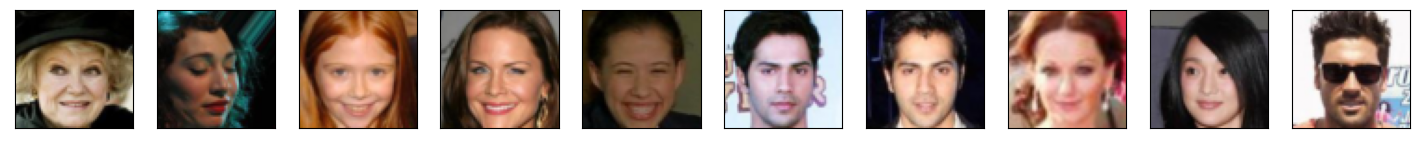

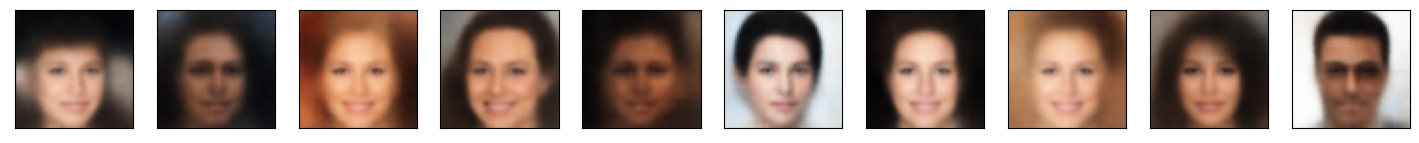

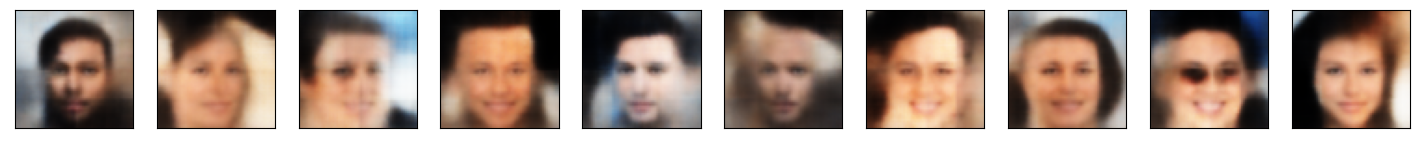

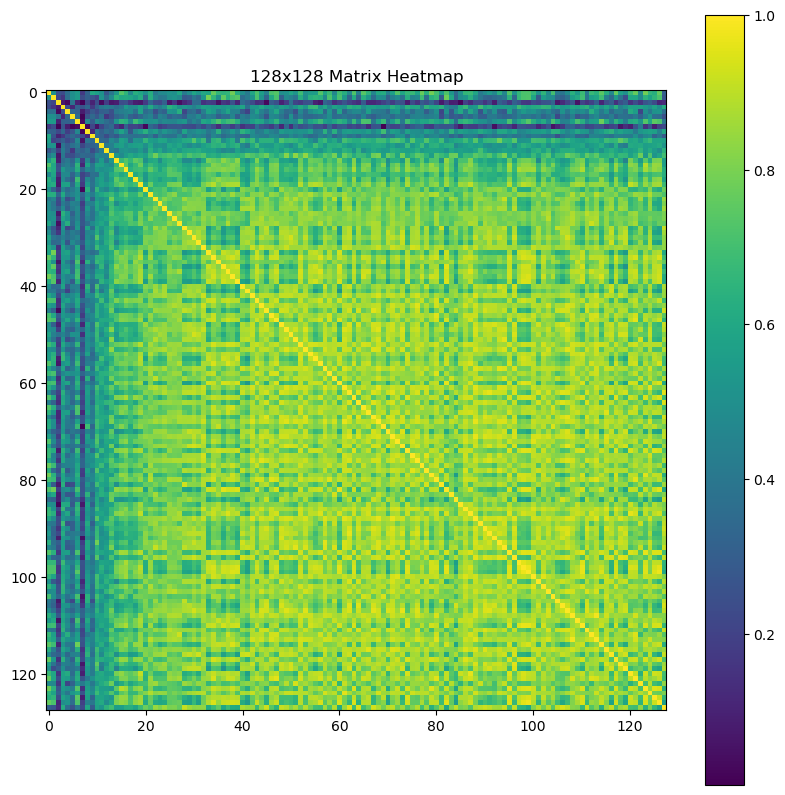

6001
lse_loss -0.6797814965248108
recon_loss 0.01636955514550209
6002
lse_loss -0.6804938912391663
recon_loss 0.015883348882198334
6003
lse_loss -0.6828616857528687
recon_loss 0.016626056283712387
6004
lse_loss -0.6825661659240723
recon_loss 0.01614345610141754
6005
lse_loss -0.6840371489524841
recon_loss 0.015805542469024658
6006
lse_loss -0.6777012348175049
recon_loss 0.015574505552649498
6007
lse_loss -0.6824323534965515
recon_loss 0.014497756026685238
6008
lse_loss -0.6848193407058716
recon_loss 0.016176052391529083
6009
lse_loss -0.6874470114707947
recon_loss 0.01507422886788845
6010
lse_loss -0.6811823844909668
recon_loss 0.017352137714624405
6011
lse_loss -0.685084879398346
recon_loss 0.01569371111690998
6012
lse_loss -0.6817508339881897
recon_loss 0.015291951596736908
6013
lse_loss -0.6838380098342896
recon_loss 0.016206439584493637
6014
lse_loss -0.6794860363006592
recon_loss 0.015333588235080242
6015
lse_loss -0.6827707290649414
recon_loss 0.01728937402367592
6016
lse_loss -0

6126
lse_loss -0.6844182014465332
recon_loss 0.015325712040066719
6127
lse_loss -0.6843582391738892
recon_loss 0.015673799440264702
6128
lse_loss -0.6825555562973022
recon_loss 0.01456565223634243
6129
lse_loss -0.6875722408294678
recon_loss 0.015641644597053528
6130
lse_loss -0.6835729479789734
recon_loss 0.01580081507563591
6131
lse_loss -0.6836010217666626
recon_loss 0.016551190987229347
6132
lse_loss -0.6867324113845825
recon_loss 0.015658963471651077
6133
lse_loss -0.6802875995635986
recon_loss 0.015905968844890594
6134
lse_loss -0.6831464171409607
recon_loss 0.01563703827559948
6135
lse_loss -0.6870279312133789
recon_loss 0.014973996207118034
6136
lse_loss -0.6824291944503784
recon_loss 0.015562042593955994
6137
lse_loss -0.6821308135986328
recon_loss 0.015842318534851074
6138
lse_loss -0.6753997802734375
recon_loss 0.01615961827337742
6139
lse_loss -0.6844449043273926
recon_loss 0.016465691849589348
6140
lse_loss -0.6855969429016113
recon_loss 0.016375858336687088
6141
lse_loss 

6251
lse_loss -0.6802003383636475
recon_loss 0.015902291983366013
6252
lse_loss -0.6851608753204346
recon_loss 0.015904586762189865
6253
lse_loss -0.6840778589248657
recon_loss 0.014844841323792934
6254
lse_loss -0.6767885684967041
recon_loss 0.016316644847393036
6255
lse_loss -0.684939980506897
recon_loss 0.016011154279112816
6256
lse_loss -0.6845074892044067
recon_loss 0.0160023495554924
6257
lse_loss -0.6815958023071289
recon_loss 0.01607750728726387
6258
lse_loss -0.67487633228302
recon_loss 0.015562309883534908
6259
lse_loss -0.6843066215515137
recon_loss 0.01586185209453106
6260
lse_loss -0.683032214641571
recon_loss 0.015472909435629845
6261
lse_loss -0.6826415061950684
recon_loss 0.015127218328416348
6262
lse_loss -0.6822231411933899
recon_loss 0.016044650226831436
6263
lse_loss -0.6848288178443909
recon_loss 0.015375050716102123
6264
lse_loss -0.6848682165145874
recon_loss 0.014669269323348999
6265
lse_loss -0.6854066848754883
recon_loss 0.014598130248486996
6266
lse_loss -0.6

6376
lse_loss -0.6843259334564209
recon_loss 0.015664367005228996
6377
lse_loss -0.6875496506690979
recon_loss 0.015729695558547974
6378
lse_loss -0.6882555484771729
recon_loss 0.015812024474143982
6379
lse_loss -0.6832769513130188
recon_loss 0.015095117501914501
6380
lse_loss -0.6880156397819519
recon_loss 0.016284851357340813
6381
lse_loss -0.6879454255104065
recon_loss 0.015698397532105446
6382
lse_loss -0.6832074522972107
recon_loss 0.01589762419462204
6383
lse_loss -0.6794934868812561
recon_loss 0.014846963807940483
6384
lse_loss -0.6799590587615967
recon_loss 0.01721993461251259
6385
lse_loss -0.6814838647842407
recon_loss 0.01583023928105831
6386
lse_loss -0.6837598085403442
recon_loss 0.015628373250365257
6387
lse_loss -0.6821000576019287
recon_loss 0.014810423366725445
6388
lse_loss -0.6823329329490662
recon_loss 0.015097446739673615
6389
lse_loss -0.6850148439407349
recon_loss 0.016689851880073547
6390
lse_loss -0.6861989498138428
recon_loss 0.017285596579313278
6391
lse_loss

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M, temperature=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 5e-1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            print(torch.exp(model_list[0].latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
        
            corrcoef = torch.corrcoef(data['z_copy'].T).abs().data.cpu().numpy()
            # Plotting the matrix as a heatmap
            plt.figure(figsize=(10, 10))
            plt.imshow(corrcoef, cmap='viridis')
            plt.colorbar()
            plt.title('128x128 Matrix Heatmap')
            plt.show()
            
            corrcoef = np.mean(corrcoef * (1-np.eye(len(corrcoef))))
            writer.add_scalar('corrcoef', corrcoef, step)
    
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [17]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


In [13]:
print('done')

done
